#Mount del drive e installazione/importazione librerie necessarie

In [ ]:
!pip install torch torchvision
!pip install rasterio
!pip install geopandas
!pip install matplotlib
!pip install albumentations
!pip install tqdm
!pip install seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 33.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
percorso =  "/content/drive/MyDrive/Progetto_laboratorio"
import sys
sys.path.append(percorso)
import fiona
import os
from torch.utils.data import DataLoader, ConcatDataset, Subset

import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.nn.functional as F


Mounted at /content/drive


In [ ]:
import importlib
import dataset
importlib.reload(dataset)
import model_unet
importlib.reload(model_unet)
from dataset import Dataset
from model_unet import UNET


In [ ]:
import utils
importlib.reload(utils)
from utils import (
    save_checkpoint,
    load_checkpoint,
    calculate_metrics,
    calculate_metrics_with_threshold,
    plot_and_save_metrics,
    save_confusion_matrix,
    plot_and_save_metrics_test,
    calculate_confusion_matrix,
)

In [ ]:
#Hyperparameters
LEARNING_RATE = [1e-2,1e-3,1e-4,1e-5]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
NUM_EPOCHS = 25
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = percorso + '/Dataset/train'
VAL_DIR = percorso + "/Dataset/validation"
TEST_DIR = percorso + "/Dataset/test"



In [ ]:
#permette la riproducibilità degli esperimenti, cioè ogni volta che si esegue l'addestramento avremo gli stessi risultati
import random
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


##Funzione di training

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
  train_loss = 0.0
  model.train()                                                    #imposta il modello in training mode
  loop = tqdm(loader)                                       #progress bar

  for batch_idx, (data, targets) in enumerate(loop):                       #iteriamo sui batch forniti dal loader
    if (data.shape[1] != 6 and data.shape[3] == 6):
      data = data.permute(0,3,1,2)
    if (data.shape[1] != 6 and data.shape[2] != 6):
      data = data.permute(0,2,1,3)
    data = data.to(device = DEVICE)                                      #sposta i dati sul device , CPU o GPU
    targets = targets.float().unsqueeze(1).to(device = DEVICE)             #convertiamo targets in float e aggiungiamo una dimensione extra
    # forward
    with torch.amp.autocast('cuda'):                                     #abilita il mixed precision training
      predictions = model(data)                                          #calcoliamo predizioni
      loss = loss_fn(predictions, targets)                             #calcoliamo la loss


    # backward
    optimizer.zero_grad()                                                  #azzera i gradienti dell'optimizer
    scaler.scale(loss).backward()                                          #scala la loss e calcola i gradienti con backward
    scaler.step(optimizer)                                                 #aggiorna i parametri
    scaler.update()                                                        #aggiorna lo scaler

    train_loss+=loss.item()

    # update tqdm loop
    loop.set_postfix(loss = loss.item())                                     #aggiorna il progress bar con il valore della loss

  train_loss/=len(loader)
  return train_loss



#Creazione Dataset e data augmentation


In [ ]:
train_transform_aug = A.Compose([
    A.HorizontalFlip(p=0.5),                 # Esegue un flip orizzontale dell'immagine con probabilità del 50%
    A.VerticalFlip(p=1.0),                   # Esegue un flip verticale dell'immagine con probabilità del 10%
    A.Rotate(limit=180, p=1.0),               # Ruota l'immagine di un angolo casuale tra -35 e 35 gradi con probabilità del 100%
    #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    #A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    #A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    #A.GaussNoise(var_limit=(10.0, 50.0), clip=True, p=0.2),
    #A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
    A.Normalize(
        mean=[0.3717, 0.3821, 0.3818, 0.3832, 0.3817, 0.3792],                # Normalizza l'immagine impostando la media dei canali a 0
        std=[0.1270, 0.1305, 0.1307, 0.1353, 0.1345, 0.1334],                 # Normalizza l'immagine impostando la deviazione standard dei canali a 1
        max_pixel_value=255.0,               # Imposta il valore massimo dei pixel a 255
    ),
    #A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    ToTensorV2(),                            # Converte l'immagine in un tensore PyTorch
],is_check_shapes=False)                    # Disabilita il controllo delle forme

train_transform_no_aug = A.Compose([
     A.Normalize(
        mean=[0.3717, 0.3821, 0.3818, 0.3832, 0.3817, 0.3792],                # Normalizza l'immagine impostando la media dei canali a 0
        std=[0.1270, 0.1305, 0.1307, 0.1353, 0.1345, 0.1334],                 # Normalizza l'immagine impostando la deviazione standard dei canali a 1
        max_pixel_value=255.0,               # Imposta il valore massimo dei pixel a 255
    ),
      ToTensorV2(),
  ], is_check_shapes=False)

val_transform = A.Compose([
    A.Normalize(
        mean=[0.3717, 0.3821, 0.3818, 0.3832, 0.3817, 0.3792],                # Normalizza l'immagine impostando la media dei canali a 0
        std=[0.1270, 0.1305, 0.1307, 0.1353, 0.1345, 0.1334],                 # Normalizza l'immagine impostando la deviazione standard dei canali a 1
        max_pixel_value=255.0,               # Imposta il valore massimo dei pixel a 255
    ),
    ToTensorV2(),
], is_check_shapes=False)


##Crezione/caricamento dataset con calcolo frequenza delle classi negative/positive

In [ ]:

#train_ds_aug1 = dataset.Dataset(root = percorso+"/Dataset/train",transform = None,patch_size=256,is_train=True)
#train_ds_no_aug = dataset.Dataset(root = percorso + "/Dataset/train",transform = train_transform_no_aug,patch_size=128,is_train=True)
#val_ds = dataset.Dataset(root = percorso + "/Dataset/validation" , transform = None,patch_size=256, is_train=False)
#val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=PIN_MEMORY)
#torch.save(val_ds, percorso + '/val_ds_last_first.pt')
#chunk_size = 1000  # Numero di campioni per ogni parte
#for i in range(0, len(train_ds_no_aug), chunk_size):
#    chunk = [train_ds_no_aug[j] for j in range(i, min(i + chunk_size, len(train_ds_no_aug)))]
#    torch.save(chunk, f'{percorso}/dataset_last_first_part_{i // chunk_size}.pt')
#print(len(train_ds_no_aug))
#print(train_ds_aug[0][0])
#train_ds_aug_parts = []
#for i in range(0, 6):
#    part = torch.load(percorso + f'/dataset_last_first_part_{i}.pt')
#    train_ds_aug_parts.append(part)
train_ds_aug = dataset.Dataset(root = percorso,transform = train_transform_aug,patch_size=256,is_train=True)
train_ds_no_aug = dataset.Dataset(root = percorso ,transform = train_transform_no_aug,patch_size=256,is_train=True)
#train_ds_aug1 = ConcatDataset(train_ds_aug_parts)
train_ds_aug1=torch.load(percorso+'/dataset_last_first_part_0.pt')
train_ds_no_aug.add_patches(train_ds_aug1)
train_ds_aug.add_patches(train_ds_no_aug)
train_ds_no_aug.transform=train_transform_no_aug
train_ds_aug.transform=train_transform_aug
train_ds_no_aug.is_train=False
train_ds_aug.is_train=True
val_ds_load = torch.load(percorso + '/val_ds_last_first.pt')
val_ds = dataset.Dataset(root = percorso,transform = val_transform,patch_size=256,is_train=True)
val_ds.add_patches(val_ds_load)
val_ds.transform=val_transform
val_ds.is_train=False
#Calcola le occorrenze di ogni classe
class_counts = torch.zeros(2)
mask_list = []

for i in range(len(train_ds_no_aug)):
  _, mask = train_ds_no_aug[i]
  mask_list.append(mask)
  class_counts += torch.bincount(mask.flatten(), minlength=2)
print(class_counts)

  # Sostituisci i valori negativi con un piccolo valore positivo



True
torch.Size([256, 256])


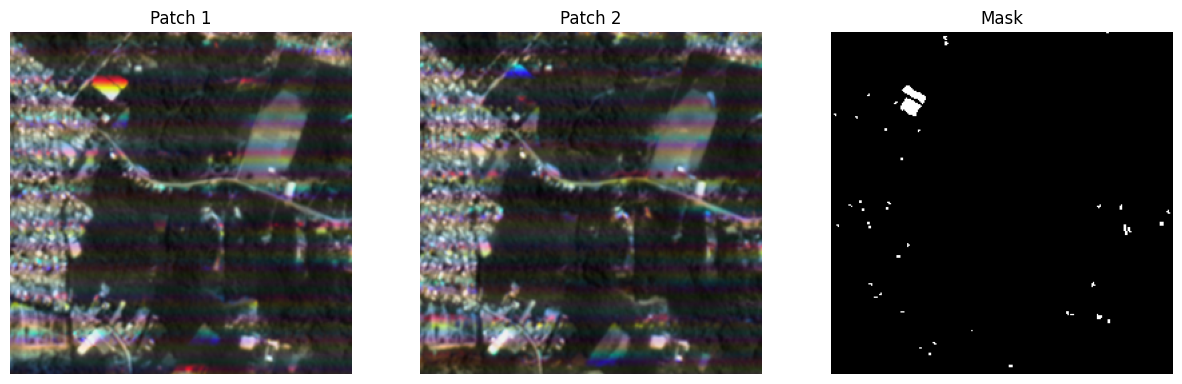

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
train_ds_no_aug.transform=train_transform_no_aug
train_ds_aug.transform=train_transform_aug
val_ds.transform=val_transform

def plot_patches_and_mask(dataset, idx):
    # Ottieni la patch concatenata e la maschera dal dataset
    concatenated_patch, mask = dataset[idx]
    print(mask.shape)
    if concatenated_patch.shape[1] == 6:
      concatenated_patch = concatenated_patch.permute(1,2,0)
    if concatenated_patch.shape[2] == 6:
      concatenated_patch = concatenated_patch.permute(2,0,1)

    # Dividi la patch concatenata in due patch separate
    patch1 = concatenated_patch[:3, :, :]
    patch2 = concatenated_patch[3:, :, :]

    # Converti i tensori in numpy array per la visualizzazione
    patch1 = patch1.permute(1, 2, 0).numpy()
    patch2 = patch2.permute(1, 2, 0).numpy()
    mask = mask

    mean = np.array([0.4822, 0.4194, 0.3123])  # per i tre canali dell'immagine
    std = np.array([0.1306, 0.1058, 0.0937])

# Espandi le dimensioni di mean e std per il broadcasting
    mean = mean[:, None, None]
    std = std[:, None, None]

    #patch1 = patch1 * std[np.newaxis, np.newaxis, :] + mean[np.newaxis, np.newaxis, :]
    #patch2 = patch2 * std[np.newaxis, np.newaxis, :] + mean[np.newaxis, np.newaxis, :]
    patch1 = (patch1 - patch1.min()) / (patch1.max() - patch1.min())
    patch2 = (patch2 - patch2.min()) / (patch2.max() - patch2.min())
    #print(patch1)
    #print(np.unique(mask))
    # Stampa le patch e la maschera
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))


    axs[0].imshow(patch1)
    axs[0].set_title('Patch 1')
    axs[0].axis('off')

    axs[1].imshow(patch2)
    axs[1].set_title('Patch 2')
    axs[1].axis('off')

    axs[2].imshow(mask, cmap='gray')
    axs[2].set_title('Mask')
    axs[2].axis('off')

    plt.show()

# Esempio di utilizzo
# Supponiamo di avere un dataset già pronto
#test_ds = dataset.Dataset(root = percorso + "/Dataset/test",transform = None,patch_size=128,is_train=True)
#test_ds.transform = val_transform
print(isinstance(val_ds,Dataset))
plot_patches_and_mask(train_ds_aug, idx=69)



##Calcolo mean e std sul dataset per normalizzare successivamente il dataset

In [ ]:

train_transform_no_aug = A.Compose([
      A.ToFloat(max_value=255.0),
      ToTensorV2(),
  ], is_check_shapes=False)

#train_ds_no_aug = dataset.Dataset(root = percorso + "/Dataset/train",transform = train_transform_no_aug,patch_size=128,is_train=True)
train_ds_no_aug.transform=train_transform_no_aug
train_loader_no_aug = DataLoader(train_ds_no_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=PIN_MEMORY)
mean_first_three = 0.0
std_first_three = 0.0
mean_last_three = 0.0
std_last_three = 0.0
nb_samples = 0

for data, _ in train_loader_no_aug:  # Ignora le maschere per il calcolo delle statistiche
    batch_samples = data.size(0)
    data_first_three = data[:, :3, :, :].view(batch_samples, 3, -1)  # Primi tre canali, view riorganizza in modo a da avere dimensione
    data_last_three = data[:, 3:, :, :].view(batch_samples, 3, -1)  # Ultimi tre canali

    mean_first_three += data_first_three.mean(2).sum(0)            #calcola la media lungo la dimensione 2 e la somma per tutti i campioni del batch
    std_first_three += data_first_three.std(2).sum(0)
    mean_last_three += data_last_three.mean(2).sum(0)
    std_last_three += data_last_three.std(2).sum(0)
    nb_samples += batch_samples

mean_first_three /= nb_samples
std_first_three /= nb_samples
mean_last_three /= nb_samples
std_last_three /= nb_samples

# Media delle statistiche di entrambi i set di canali
mean_combined = (mean_first_three + mean_last_three) / 2
std_combined = (std_first_three + std_last_three) / 2

print(f'Mean (first three channels): {mean_first_three}, Std (first three channels): {std_first_three}')
print(f'Mean (last three channels): {mean_last_three}, Std (last three channels): {std_last_three}')
print(f'Mean (combined): {mean_combined}, Std (combined): {std_combined}')


Mean (first three channels): tensor([0.3717, 0.3821, 0.3818]), Std (first three channels): tensor([0.1270, 0.1305, 0.1307])
Mean (last three channels): tensor([0.3832, 0.3817, 0.3792]), Std (last three channels): tensor([0.1353, 0.1345, 0.1334])
Mean (combined): tensor([0.3774, 0.3819, 0.3805]), Std (combined): tensor([0.1311, 0.1325, 0.1320])


#Implementazione earlystopping


In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

#Implementazione FocalLoss

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.99, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        F_loss = alpha_t * (1 - pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

#Training e prova del modello

In [ ]:
import json
def load__checkpoint(checkpoint_path, model, optimizer, scheduler, scaler):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    best_f1 = checkpoint['best_f1']
    return epoch, model, best_f1, optimizer, scheduler, scaler


In [ ]:

def main():
  output_dir = percorso + "/outputs"
  train_loader_aug = DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=PIN_MEMORY)
  val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=PIN_MEMORY)
  subset_indices_train = np.random.choice(len(train_ds_no_aug), size=int(0.05 * len(train_ds_no_aug)), replace=False)      #replace=False indica che un esempio non puo essere preso piu di una volta
  subset_indices_val = np.random.choice(len(val_ds), size=int(0.05 * len(val_ds)), replace=False)      #replace=False indica che un esempio non puo essere preso piu di una volta
  train_subset = Subset(train_ds_no_aug, subset_indices_train)
  val_subset = Subset(val_ds,subset_indices_val)
  factor = 0.5
  metrics = {
    'train_losses': [],
    'val_losses': [],
    'train_precisions': [],
    'val_precisions': [],
    'train_recalls': [],
    'val_recalls': [],
    'train_f1s': [],
    'val_f1s': [],
    'train_accuracies': [],
    'val_accuracies': []
  }


# Creare un DataLoader per il sottoinsieme
  train_subset_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=PIN_MEMORY)
  val_subset_loader = DataLoader(val_subset,batch_size = BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=PIN_MEMORY)
  pos_weight = class_counts[0] / class_counts[1]              #per bilanciare le classi con 1 classe minoritaria e 0 classe maggioritaria

  checkpoint_path = "/content/drive/MyDrive/Progetto_laboratorio/checkpoint.pth"
  metrics_file_path = "/content/drive/MyDrive/Progetto_laboratorio/metrics.json"
  model = UNET(in_channels=6, out_channels=1).to(device = DEVICE)
  start_epoch=0
  loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(DEVICE)
  early_stopping = EarlyStopping(patience=10, min_delta=0.01)
  optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)         #weight_decay aiuta a prevenire che i pesi diventino troppo grandi aggiungendo una 'penalità' ai pesi
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",factor=factor,patience=5)                 #riduce il lr di 0.1 quando il f1 score smette di migliorare con pazienza di 3 epoche
  scaler = torch.amp.GradScaler('cuda')                           #utilizzato per mixed precision training, aumenta la velocità e l'efficienza senza perdere di precisione, utilizza mix di float16 e float32
  metrics = {
      'train_losses': [],
      'val_losses': [],
      'train_precisions': [],
      'val_precisions': [],
      'train_recalls': [],
      'val_recalls': [],
      'train_f1s': [],
      'val_f1s': [],
      'train_accuracies': [],
      'val_accuracies': []
      }
  start_epoch=25
  best_f1=0.0
  _, _, best_f1, _, _, _ = load__checkpoint(checkpoint_path, model, optimizer, scheduler,scaler)
  for lr in LEARNING_RATE:
    print('Proviamo lr : ',lr)
    for weight_decay in [1e-4,1e-5]:
      print('Proviamo weight decay : ',weight_decay)
      print('Best F1 trovato fino ad ora : ',best_f1)
      checkpoint_path = "/content/drive/MyDrive/Progetto_laboratorio/checkpoint.pth"
      #start_epoch, model, best_f1, optimizer, scheduler, scaler = load_checkpoint(checkpoint_path, model, optimizer, scheduler, scaler)
      loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(DEVICE)
      if (start_epoch == 25):
        model = UNET(in_channels=6, out_channels=1).to(device = DEVICE)
        start_epoch=0
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(DEVICE)
        early_stopping = EarlyStopping(patience=10, min_delta=0.001)
        optimizer = optim.Adam(model.parameters(), lr, weight_decay=weight_decay)         #weight_decay aiuta a prevenire che i pesi diventino troppo grandi aggiungendo una 'penalità' ai pesi
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",factor=factor,patience=4)                 #riduce il lr di 0.1 quando il f1 score smette di migliorare con pazienza di 3 epoche
        scaler = torch.amp.GradScaler('cuda')                           #utilizzato per mixed precision training, aumenta la velocità e l'efficienza senza perdere di precisione, utilizza mix di float16 e float32
        metrics = {
            'train_losses': [],
            'val_losses': [],
            'train_precisions': [],
            'val_precisions': [],
            'train_recalls': [],
            'val_recalls': [],
            'train_f1s': [],
            'val_f1s': [],
            'train_accuracies': [],
            'val_accuracies': []
            }
      set_seed(42)

      print("Training")

      for epoch in range (start_epoch,NUM_EPOCHS):
        print('Epoca n. ', epoch)
        print('lr : ',scheduler.get_last_lr())
        train_loss=train_fn(loader=train_loader_aug,model=model, optimizer=optimizer, loss_fn=loss_fn, scaler=scaler)

        metrics['train_losses'].append(train_loss)

        val_loss= 0.0
        with torch.no_grad():
          for images,labels in val_loader:
            if (images.shape[1] != 6 and images.shape[3] == 6):
              images = images.permute(0,3,1,2)
            if (images.shape[1] != 6 and images.shape[2] != 6):
              images = images.permute(0,2,1,3)
            images = images.to(DEVICE)
            labels = labels.float().unsqueeze(1).to(DEVICE)
            outputs = model(images)
            loss = loss_fn(outputs,labels)
            val_loss+=loss.item()

          val_loss/=len(val_loader)
          metrics['val_losses'].append(val_loss)

        f1_val,best_threshold = calculate_metrics_with_threshold(loader=val_subset_loader,model=model,device=DEVICE)
        accuracy_val,precision_val,recall_val,f1_val = calculate_metrics(loader=val_loader,model=model,device=DEVICE,threshold=best_threshold)
        confusion_matrix_val = calculate_confusion_matrix(loader=val_loader,model=model,device=DEVICE,threshold=best_threshold)

        metrics['val_precisions'].append(precision_val)
        metrics['val_recalls'].append(recall_val)
        metrics['val_f1s'].append(f1_val)
        metrics['val_accuracies'].append(accuracy_val)

        accuracy_train,precision_train,recall_train,f1_train = calculate_metrics(loader=train_subset_loader,model=model,device=DEVICE,threshold=best_threshold)
        metrics['train_precisions'].append(precision_train)
        metrics['train_recalls'].append(recall_train)
        metrics['train_f1s'].append(f1_train)
        metrics['train_accuracies'].append(accuracy_train)

        print('train loss: ',train_loss)
        print('val_loss : ',val_loss)
        print('train accuracy : ',accuracy_train)
        print('train precision : ',precision_train)
        print('train recall : ', recall_train)
        print('train f1 : ', f1_train)
        print('val accuracy : ',accuracy_val)
        print('val precision : ',precision_val)
        print('val recall : ', recall_val)
        print('val f1 : ', f1_val)
        save_confusion_matrix(confusion_matrix_val, output_dir, epoch, lr, weight_decay, factor)

        if f1_val > best_f1:
          best_f1 = f1_val
          print(f"Nuovo miglior F1-score: {f1_val}. Salvataggio del modello...")
          model_save_name = 'best_model.pth'
          path = F"/content/drive/MyDrive/Progetto_laboratorio/{model_save_name}"
          torch.save({
              'model_state_dict': model.state_dict(),
              'best_threshold': best_threshold
          }, path)

        scheduler.step(val_loss)
        early_stopping(f1_val)
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'best_f1': best_f1
        }
        checkpoint_path = F"/content/drive/MyDrive/Progetto_laboratorio/checkpoint.pth"
        torch.save(checkpoint, checkpoint_path)

        if early_stopping.early_stop:
          print("Early stopping")
          break

      plot_and_save_metrics(metrics['train_losses'], metrics['val_losses'], metrics['train_precisions'], metrics['val_precisions'], metrics['train_recalls'], metrics['val_recalls'], metrics['train_accuracies'], metrics['val_accuracies'], metrics['train_f1s'], metrics['val_f1s'], lr, weight_decay, factor, output_dir)
  print("Best F1-score:", best_f1)



In [ ]:

if __name__ == "__main__":
  try:
      torch.multiprocessing.set_start_method('spawn', force=True)
  except RuntimeError:
      pass
  torch.cuda.empty_cache()
  main()


In [ ]:
model = UNET(in_channels=6, out_channels=1).to(device=DEVICE)

# Carica i pesi salvati
model.load_state_dict(torch.load(percorso + '/best_model.pth'))
model.eval()  # Imposta il modello in modalità di valutazione

test_ds = dataset.Dataset(root=percorso + "/Dataset/test", transform=val_transform,is_Train=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=PIN_MEMORY)
subset_indices_test = np.random.choice(len(test_ds), size=int(0.1 * len(test_ds)), replace=False)      #replace=False indica che un esempio non puo essere preso piu di una volta
test_subset = Subset(test_ds, subset_indices_test)
test_subset_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=PIN_MEMORY)
_,threshold = calculate_metrics_val(loader=test_subset_loader,model=model,device=DEVICE)
def evaluate_model(loader, threshold, model, device):
    model.eval()

    accuracy, precision, recall, f1 = calculate_metrics_train(loader, model)
    return accuracy, precision, recall, f1

# Valuta il modello sul test set
accuracy, precision, recall, f1 = evaluate_model(test_loader, threshold , model, DEVICE)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-score: {f1:.4f}")

metrics = accuracy, precision, recall, f1  # Esempio di valori per accuracy, precision, recall, F1-score
plot_and_save_metrics_test(metrics,percorso+'/outputs')